<a href="https://colab.research.google.com/github/nbkwon/ml-assignment/blob/master/ml_assignment9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# we now need pyplot for plotting data
import matplotlib.pyplot as pyplot
def show_plot(download_file = False):
    pyplot.legend()
    pyplot.show()
    if download_file == False:
       return
    
    import google.colab
    file_name = "test.png"
    pyplot.savefig(file_name)
    google.colab.files.download(file_name)

def make_plot(plot_data_list, use_this = None):
    # it's too samll. make bigger.
    if use_this is None:
        pyplot.figure(figsize=(8, 8))
    else:
        # use_this.set_figheight(8)
        # use_this.set_figwidth(8)
        pass

    for data_dic, plot_type, color, label in plot_data_list:
        if plot_type is "plot":
            if use_this is None:
                pyplot.plot(list(data_dic.keys()), list(data_dic.values()), c=color, label=label)
            else:
                use_this.plot(list(data_dic.keys()), list(data_dic.values()), c=color, label=label)    
        if plot_type is "scatter":
            if use_this is None:
                pyplot.scatter(list(data_dic.keys()), list(data_dic.values()), c=color, label=label)
            else:
                use_this.scatter(list(data_dic.keys()), list(data_dic.values()), c=color, label=label)

10000


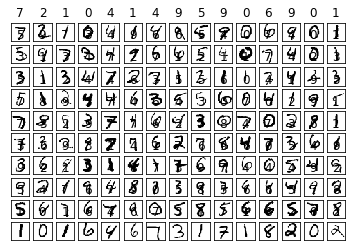

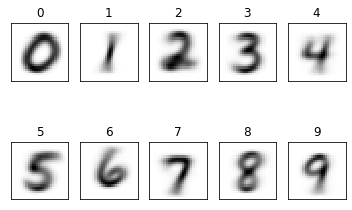

In [187]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit, njit, vectorize, cuda
from numpy import arange


file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

@jit
def normalize(data):
    data_normalized = (data - min(data)) / (max(data) - min(data))
    return(data_normalized)

@jit
def distance(x, y):
    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:
    
    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1

print(count)
#
# plot first 150 images out of 10,000 with their labels
#
f1 = plt.figure(1)

for i in range(150):

    label       = list_label[i]
    im_vector   = list_image[:, i]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(10, 15, i+1)
    plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)


#plt.show()

#
# plot the average image of all the images for each digit
#
f2 = plt.figure(2)

im_average  = np.zeros((size_row * size_col, 10), dtype=float)
im_count    = np.zeros(10, dtype=int)

for i in range(num_image):

    im_average[:, list_label[i]] += list_image[:, i]
    im_count[list_label[i]] += 1

for i in range(10):

    im_average[:, i] /= im_count[i]

    plt.subplot(2, 5, i+1)
    plt.title(i)
    plt.imshow(im_average[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()


In [188]:
from functools import reduce

def check_convergence(loss, loss_after):
    # float 형의 자료형 동일한지 판단을 위해 numpy의 isclose를 사용.
    # atol = 0.0000000000000000001
    return np.isclose(loss, loss_after)
    # return numpy.isclose(theta_list, new_theta_list)

def sigmoid_one(value):
    return 1 / (1 + np.exp(-value))

def sigmoid(value):
    return 1 / (1 + np.exp(-value))

def vstack(f):
    return np.vstack([f, [1]])

@njit
def npmul(a, b):
    # @ 랑 matmul이랑 차이 없음을 확인함.
    # return np.matmul(a,b)
    return a @ b

#결과를 list로 반환
def get_by_mat(mat_list, factor_list):
    result_list = []

    factors = factor_list
    result_list.append(factors)

    for mat in mat_list:
        factors_with_bias = vstack(factors)
        factors = npmul(mat, factors_with_bias)
        # print("before", factors)
        # result_list.append(factors)
        factors = sigmoid(factors)
        # print("after", factors)
        result_list.append(factors)
    
    return result_list
    

label_unique = np.unique(list_label)
theta_list = np.random.normal(0, 1, size_row * size_col)

# numpy.matmul()
d = np.ones((784,1), dtype=np.float64)


# l = get_by_mat([x_to_y_matrix, y_to_z_matrix, z_to_h_matrix], d)
# for i in l:
#     print(i)
# a = [d, x_to_y_matrix, y_to_z_matrix, z_to_h_matrix]
# a.reverse()
# print(reduce(np.matmul, a))

@njit
def log(n):
    float_min = 0.00000000000000001
    return np.log(max(n, float_min))

def get_f_l(f_list, c):
    return f_list[:, c].reshape((-1,1))

def get_ret_list_by_c(mat_list, f_list, d_list):
    ret_list_by_c = []
    m = len(d_list)

    for c in range(m):
        factor_list= get_f_l(f_list, c)
        
        ret = get_by_mat(mat_list, factor_list)

        ret_list_by_c.append(ret)
    
    return ret_list_by_c

def calc_energy_value(mat_list, f_list, d_list, ret_list_by_c):
    ret = 0

    m = len(d_list)

    # factor_list = 시작 x들의 값
    # r_in_d = one_hot_encode으로 답인 거
    for c in range(m):
        ret_list = ret_list_by_c[c]
        l_in_d_list = d_list[c]

        for r_in_d, ret in zip(l_in_d_list, ret_list[-1]):
            ret = ret[0]
            calculated = -r_in_d * log(ret) - (1 - r_in_d) * log(1 - ret)
            # print(type(r_in_d), type(ret), type(calculated))
            ret = ret + calculated

    return ret / m

def calc_next_gradient(lr, mat_list, f_list, d_list, ret_list_by_c):
    
    # 10은 고정값.
    error_list = np.zeros(10, dtype=np.float64)

    m = len(d_list)
    acc_ret_list = None
    for c in range(m):
        ret_list = ret_list_by_c[c]
        l_in_d_list = d_list[c]

        if acc_ret_list is None:
            acc_ret_list = ret_list
        else:
            for i in range(len(acc_ret_list)):
                acc_ret_list[i] = np.add(acc_ret_list[i], ret_list[i])

        for idx, (r_in_d, ret) in enumerate(zip(l_in_d_list, ret_list[-1])):
            ret = ret[0]
            calculated = ret - r_in_d
            
            error_list[idx] = error_list[idx] + calculated

    error_list = error_list / m

    # print(error_list)

    for i in range(len(acc_ret_list)):
        acc_ret_list[i] = acc_ret_list[i] / m

    # print(f"mat len {len(mat_list)} ret_list len {len(ret_list)}")
    new_mat_list = []

    for i in range(len(mat_list)-1, -1, -1):
        now_mat = mat_list[i]
        new_mat = now_mat.copy()
        sigmoided_output = acc_ret_list[i]
        # Gradient Descent 로 갱신한 매트릭스 생ㅅ어
        
        # matrix 갱신
        # print(f"sigmoided_output {len(sigmoided_output)}")
        for iy,ix in np.ndindex(now_mat.shape):
             
            if ix >= len(sigmoided_output):
                # bias는 이 값이 1이라 생각하는 곳이기 때문이다.
                sigmoided_output_val = 1
            else:
                sigmoided_output_val = sigmoided_output[ix]
                
            # print(f"iy {iy}, ix {ix} ")
            # print(error_list[iy])
            now_mat[iy, ix]
            
            new_mat[iy,ix] =  now_mat[iy, ix] - lr * sigmoided_output_val * error_list[iy]
            # if(now_mat[iy, ix] != new_mat[iy,ix]):
            #     print("다르구만")

        new_mat_list.append(new_mat)
        # error_list 갱신
        # 이전 레이어의 에러를 미리 계산하는거라서 끝난상황이면 갱신할 필요가 없다.
        if(i - 1 < 0):
            continue

        new_error_list = np.zeros(len(acc_ret_list[i]), dtype=np.float64)
        
        m = len(d_list)
        # print("now_mat",now_mat.shape)
        for c in range(len(new_error_list)):
            acc = 0
            # - 1 로 bias 레이어 제거
            for to_y_idx in range(len(now_mat[:])):
                w_list = now_mat[:, to_y_idx]
                # print(f"len w_list{len(w_list)} error_list {len(error_list)}")
                v = acc_ret_list[i - 1][c]
                s = sigmoid_one(v) * (1 - sigmoid_one(v))
                new_error_list[c] = s * np.dot(w_list, error_list)
        
        error_list = new_error_list
    
    # print("new_mat_list len", len(new_mat_list))
    new_mat_list.reverse()

    return new_mat_list

def get_classified_label(output_ret):
    m = max(output_ret)
    expected = np.where(output_ret == m)[0]
    # print("out: ", output_ret, "max:", m, "expected", expected)
    [e] = list(expected)
    return e

def same_check(output_ret, answer_label):
    e = get_classified_label(output_ret)

    return answer_label[e] == 1

def calc_accuracy(ret_list_by_c, answer_list):
    count = len(answer_list)
    corrected = 0
    for ret_list, answer in zip(ret_list_by_c, answer_list):
        output_ret = ret_list[-1]
        if same_check(output_ret, answer):
            corrected = corrected + 1

    return  corrected / count

# https://newsight.tistory.com/70

# r = np.zeros(10, dtype=np.float64)
# r[0] = 1
# d_dict = [(d, r)]
# print(calc_energy_value([x_to_y_matrix, y_to_z_matrix, z_to_h_matrix], d_dict))
@njit
def to_label_list(x):
    l = np.zeros(10, dtype=np.float64)
    l[x] = 1
    return l

# print(list_label)

def make_thetas(x, y, mul):
    a = np.random.normal(0, 1, x * y).reshape(x,y) * mul
    return a


tset = make_thetas(5, 10, 0.0039)
t = np.asarray([[1],[2],[3],[4],[5],[6],[7],[8],[9]], dtype=np.float64)
print("테스트용 계산")
print(tset, "을 여기에.", t)
print(get_by_mat([tset], t))

x_to_y_matrix = make_thetas(196, 785, 0.8)
y_to_z_matrix = make_thetas(49, 197, 1.0033)
z_to_h_matrix = make_thetas(10, 50, 1.2) * 1.5

ti = 6000 #train index
driver = lambda x: to_label_list(x)
train_list_label_arranged = np.array(list_label[:ti])
train_list_label_arranged = np.array(list(map(driver, train_list_label_arranged)))
test_list_label_arranged = np.array(list_label[ti:])
test_list_label_arranged = np.array(list(map(driver, test_list_label_arranged)))

train_image = list_image[:, :ti]
test_image = list_image[:, ti:]

step_count = 0
mats = [x_to_y_matrix, y_to_z_matrix, z_to_h_matrix]

stpcnt_train_costs = {}
stpcnt_test_costs = {}

stpcnt_train_accuracy = {}
stpcnt_test_accuracy = {}

stpcnt_mats = {}

from timeit import default_timer as timer
s = timer()
lr = 0.1

while True:
    print("loop", step_count)
    train_ret_list_by_c = get_ret_list_by_c(mats, train_image, train_list_label_arranged)
    train_cost = calc_energy_value(mats, train_image, train_list_label_arranged, train_ret_list_by_c)
    test_ret_list_by_c = get_ret_list_by_c(mats, test_image, test_list_label_arranged)
    test_cost = calc_energy_value(mats, test_image, test_list_label_arranged, test_ret_list_by_c)
    stpcnt_train_costs[step_count] = train_cost
    stpcnt_test_costs[step_count] = test_cost
    stpcnt_mats[step_count] = mats
    stpcnt_train_accuracy[step_count] = calc_accuracy(train_ret_list_by_c, train_list_label_arranged)
    stpcnt_test_accuracy[step_count] = calc_accuracy(test_ret_list_by_c, test_list_label_arranged)
    print("accu", stpcnt_train_accuracy[step_count], stpcnt_test_accuracy[step_count])
    print("loss", stpcnt_train_costs[step_count], stpcnt_test_costs[step_count])

    new_mats = calc_next_gradient(lr + np.sqrt(step_count), mats, list_image, train_list_label_arranged, train_ret_list_by_c)
    mats = new_mats

    if (step_count > 2 and check_convergence(stpcnt_train_costs[step_count-1], stpcnt_train_costs[step_count])):
        break

    step_count = step_count + 1


e = timer()
print("소요시간", e - s)
print(list(stpcnt_train_costs.values()))
print(list(stpcnt_test_costs.values()))


테스트용 계산
[[-2.85541623e-03 -2.53942485e-03 -5.18979773e-03  2.43549438e-03
   1.77506347e-03  4.65483926e-03  2.52792370e-03 -7.00002064e-03
  -7.30080912e-03 -1.33607267e-03]
 [-6.11699380e-03 -3.16293069e-03  4.81499364e-03 -1.88395846e-03
  -3.09447130e-04 -4.29217109e-03 -4.53955577e-04 -8.53598414e-04
   3.46239436e-03  5.08996875e-04]
 [-1.41094166e-03  4.47282875e-03  1.50649714e-04 -3.12581882e-03
   7.60914977e-03 -2.64210282e-03  4.58895802e-03  5.31787514e-03
   5.50573348e-03  9.46143379e-03]
 [-4.99237984e-03  5.88422961e-03  3.07612131e-03 -4.02262060e-03
   1.51281223e-03  6.67662308e-03 -1.03600923e-04  1.05773199e-03
  -7.90191050e-04  6.92803132e-04]
 [-1.82884015e-03  2.19949984e-03  2.09319905e-03 -1.12047976e-03
   1.01074427e-03  2.07955911e-03  3.91726171e-03  3.73372688e-05
   3.98493963e-03  4.05576344e-03]] 을 여기에. [[1.]
 [2.]
 [3.]
 [4.]
 [5.]
 [6.]
 [7.]
 [8.]
 [9.]]
[array([[1.],
       [2.],
       [3.],
       [4.],
       [5.],
       [6.],
       [7.],
  

In [0]:
def get_10_data(ret_list_by_c, answer_list, get_correct):
    list_image  = np.empty((size_row * size_col, 10), dtype=float)
    list_label  = np.empty(10, dtype=int)

    i = 0
    for ret_list, answer in zip(ret_list_by_c, answer_list):
        if i >= 10: 
            break

        output_ret = ret_list[-1]
        if same_check(output_ret, answer) == get_correct:
            list_image[:, i] = ret_list[0][:, 0]
            list_label[i] = get_classified_label(output_ret)
            i = i + 1

    return list_image, list_label

good_tuple = get_10_data(train_ret_list_by_c, train_list_label_arranged, True)
bad_tuple = get_10_data(test_ret_list_by_c, test_list_label_arranged, False)

In [0]:
def show_classification_example(good_tuple, bad_tuple):
    f1 = plt.figure(1)

    images, labels = good_tuple
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.title(labels[i])
        plt.imshow(images[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

        frame   = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)

    f2 = plt.figure(2)

    images, labels = bad_tuple
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.title(labels[i])
        plt.imshow(images[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

        frame   = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)


    plt.show()

1. Plot the loss curve

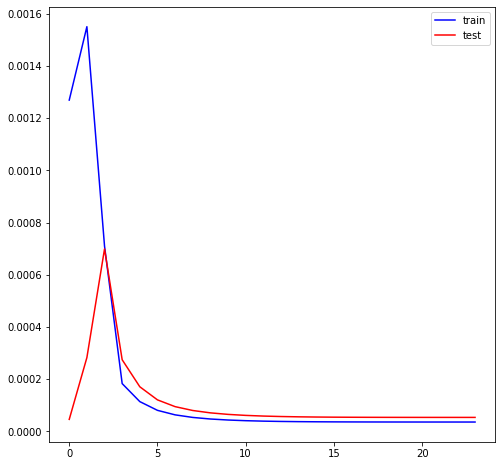

In [191]:
make_plot([(stpcnt_train_costs, "plot", "blue", "train"), (stpcnt_test_costs, "plot", "red", "test") ])
show_plot()

2. Plot the accuracy curve

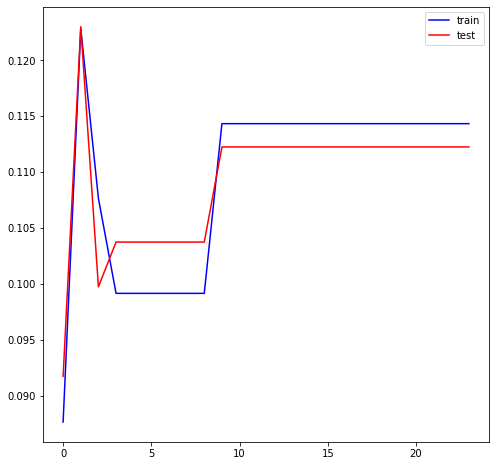

In [192]:
make_plot([(stpcnt_train_accuracy, "plot", "blue", "train"), (stpcnt_test_accuracy, "plot", "red", "test") ])
show_plot()

3. Plot the accuracy value

In [193]:
def get_last(d):
    return d[list(d.keys())[-1]]

print(f"train accuracy: {get_last(stpcnt_train_accuracy) * 100}%")
print(f"test accuracy: {get_last(stpcnt_test_accuracy) * 100}%")

train accuracy: 11.433333333333334%
test accuracy: 11.225%


4. Plot the classification example

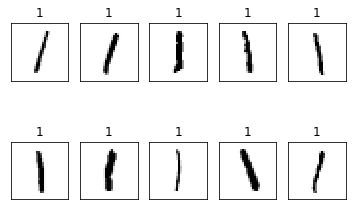

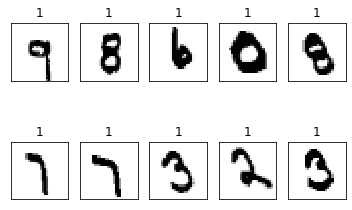

In [194]:
show_classification_example(good_tuple, bad_tuple)
